### Importation des Bibliothèques


In [1]:
import json
import pandas as pd
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import re
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from elsapy.elsclient import ElsClient
from elsapy.elssearch import ElsSearch

print(plt.style.available)

plt.style.use('ggplot')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


### Chargement des Configurations et Initialisation du Client


In [2]:
# Chargement des configurations API depuis un fichier JSON
with open("Config.json") as con_file:
    config = json.load(con_file)

# Initialisation du client ElsClient
client = ElsClient(config['apikey'])
if 'insttoken' in config:
    client.inst_token = config['insttoken']


### Fonctions de Récupération et Extraction des Publications


In [3]:
# Fonction pour récupérer des publications sur un sujet spécifique
def get_publications(topic, start=0, count=25):
    query = f"SUBJAREA({topic})"
    base_url = 'https://api.elsevier.com/content/search/scopus'
    headers = {
        'Accept': 'application/json',
        'X-ELS-APIKey': config['apikey']
    }
    params = {
        'query': query,
        'start': start,
        'count': count
    }
    
    # Utilisation de requests avec Retry pour gérer les erreurs de connexion
    session = requests.Session()
    retry_strategy = Retry(
        total=5,
        backoff_factor=1,
        status_forcelist=[500, 502, 503, 504]
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount('https://', adapter)
    
    try:
        response = session.get(base_url, headers=headers, params=params)
        response.raise_for_status()
        return response.json()['search-results']['entry']
    except requests.exceptions.RequestException as e:
        print(f"Erreur lors de la requête : {e}")
        return None

# Fonction pour extraire des champs spécifiques et retourner un DataFrame Pandas
def extract_fields_to_dataframe(publications, topic):
    data = []
    for publication in publications:
        fields = {
            'topic': topic,
            'authors': publication.get('dc:creator', ''),
            'title': publication.get('dc:title', ''),
            'publicationName': publication.get('prism:publicationName', ''),
            'doi': publication.get('prism:doi', ''),
            'volume': publication.get('prism:volume', ''),
            'issue': publication.get('prism:issueIdentifier', ''),
            'pageRange': publication.get('prism:pageRange', ''),
            'coverDate': publication.get('prism:coverDate', ''),
            'affiliation': publication.get('affiliation', ''),
            'citedbyCount': publication.get('citedby-count', 0)
        }
        data.append(fields)
    
    df = pd.DataFrame(data)
    return df

# Fonction pour récupérer un nombre total de publications avec pagination
def get_all_publications_for_topic(topic, total_count=100, batch_size=25):
    all_publications = []
    for start in range(0, total_count, batch_size):
        publications = get_publications(topic, start=start, count=batch_size)
        if not publications:
            break
        all_publications.extend(publications)
    return all_publications


### Récupération et Traitement des Données


In [4]:
topics = ['COMP', 'ENGI', 'MEDI', 'BIOC', 'CHEM', 'PHYS', 'MATH', 'ECON', 'SOCI', 'PSYC']
total_dataframes = []

for topic in topics:
    publications = get_all_publications_for_topic(topic, total_count=100)
    if publications:
        df = extract_fields_to_dataframe(publications, topic)
        total_dataframes.append(df)

# Concaténation de tous les DataFrames en un seul
merged_df = pd.concat(total_dataframes, ignore_index=True)
print(f"Récupéré {len(merged_df)} publications.")
merged_df.to_csv('publications.csv', index=False)
print("Le fichier 'publications.csv' a été sauvegardé avec succès.")


Récupéré 1000 publications.
Le fichier 'publications.csv' a été sauvegardé avec succès.


### Prétraitement des Données


In [5]:
# Chargement les données depuis le fichier CSV
df = pd.read_csv('publications.csv')

# Fonction pour extraire l'affilname et le pays depuis le champ affiliation
def extract_affiliation_details(affiliation):
    try:
        if isinstance(affiliation, str):
            affilname_match = re.search(r"'affilname': '([^']+)'", affiliation)
            country_match = re.search(r"'affiliation-country': '([^']+)'", affiliation)

            affilname = affilname_match.group(1) if affilname_match else None
            country = country_match.group(1) if country_match else None
            
            return affilname, country
        else:
            return None, None
    except Exception as e:
        print(f"Erreur lors de l'extraction de l'affiliation : {e}")
        return None, None

df[['affilname', 'affiliation-country']] = df['affiliation'].apply(
    lambda x: pd.Series(extract_affiliation_details(x))
)

# Imputation des valeurs manquantes pour les colonnes numériques avec la moyenne
imputer = SimpleImputer(strategy='mean')
df[['citedbyCount']] = imputer.fit_transform(df[['citedbyCount']])

# Imputation des valeurs manquantes pour les colonnes textuelles avec une chaîne vide
df.fillna('', inplace=True)

# Transformation des Dates
df['coverDate'] = pd.to_datetime(df['coverDate'], errors='coerce')
df['year'] = df['coverDate'].dt.year
df['month'] = df['coverDate'].dt.month

# Normalisation/Standardisation des Données
scaler = StandardScaler()
df[['citedbyCount']] = scaler.fit_transform(df[['citedbyCount']])

# Déduplication des Données
df.drop_duplicates(inplace=True)
df.to_csv('publications_preprocessed.csv', index=False)


In [6]:
# Affichage les premières lignes du DataFrame pour avoir un aperçu
print("Aperçu des premières lignes du DataFrame :")
print(df.head())



Aperçu des premières lignes du DataFrame :
  topic       authors                                              title  \
0  COMP   Adhikari A.  Survey of techniques to detect common weakness...   
1  COMP  Alguliyev R.  An approach for assessing the functional vulne...   
2  COMP     Kokila M.  Authentication, access control and scalability...   
3  COMP  Dahiphale V.  Securing IoT devices with fast and energy effi...   
4  COMP        Chu L.  A Kriging Surrogate Model for Ball Grid Array ...   

                                     publicationName  \
0                    Cyber Security and Applications   
1                    Cyber Security and Applications   
2                    Cyber Security and Applications   
3                    Cyber Security and Applications   
4  Journal of Electronic Packaging, Transactions ...   

                         doi volume issue pageRange  coverDate  \
0  10.1016/j.csa.2024.100061      3                 2025-12-01   
1  10.1016/j.csa.2024.100058   

### Analyses et Visualisations


#### 1. Analyse de citation
##### Nombre de citations par publication
Visualisation de la distribution du nombre de citations par publication pour identifier celles ayant le plus d'impact.

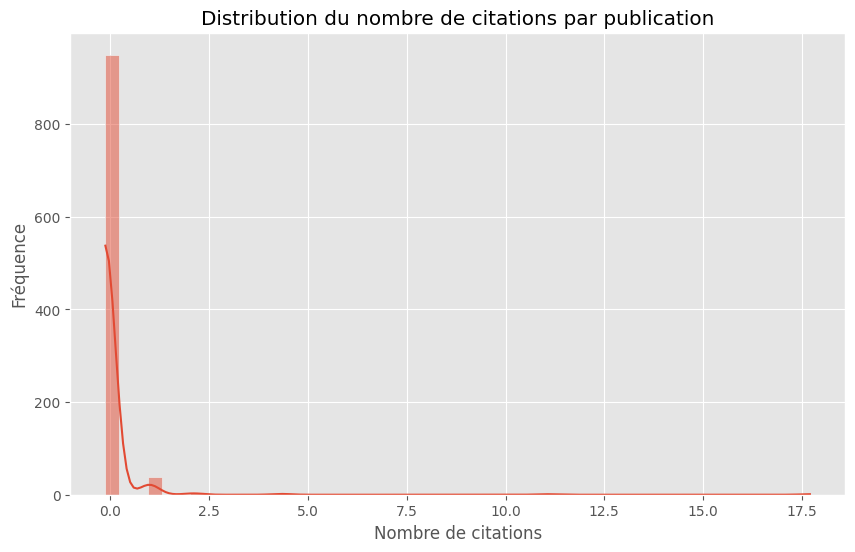

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['citedbyCount'], bins=50, kde=True)
plt.title('Distribution du nombre de citations par publication')
plt.xlabel('Nombre de citations')
plt.ylabel('Fréquence')
plt.show()



##### Tendances des citations au fil du temps
Suivi de l'évolution des citations par année pour observer l'impact au fil du temps.

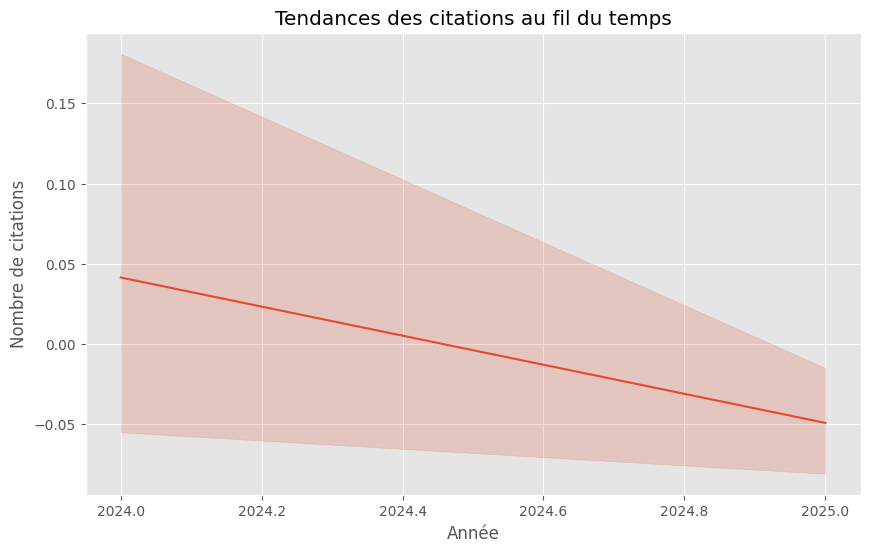

In [8]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='year', y='citedbyCount')
plt.title('Tendances des citations au fil du temps')
plt.xlabel('Année')
plt.ylabel('Nombre de citations')
plt.show()


##### Distribution des citations par auteur
Identification des auteurs les plus cités.

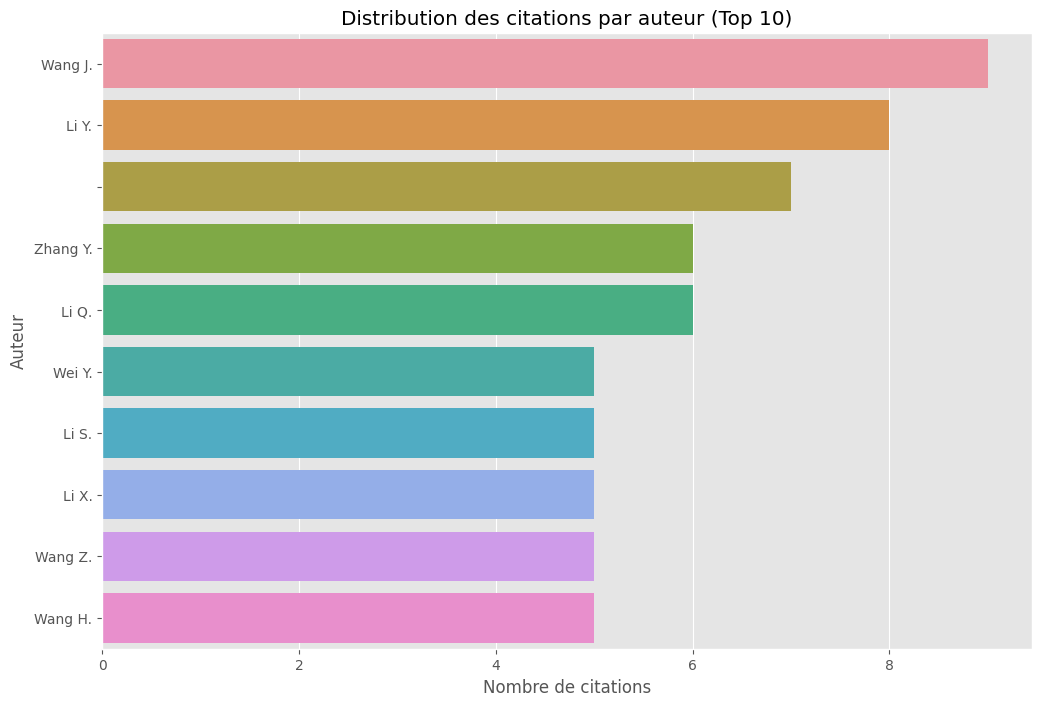

In [9]:
plt.figure(figsize=(12, 8))
top_authors = df['authors'].value_counts().head(10)
sns.barplot(x=top_authors.values, y=top_authors.index, orient='h')
plt.title('Distribution des citations par auteur (Top 10)')
plt.xlabel('Nombre de citations')
plt.ylabel('Auteur')
plt.show()


#### 2. Analyse des publications
##### Nombre de publications par auteur
Visualisation des auteurs les plus prolifiques.

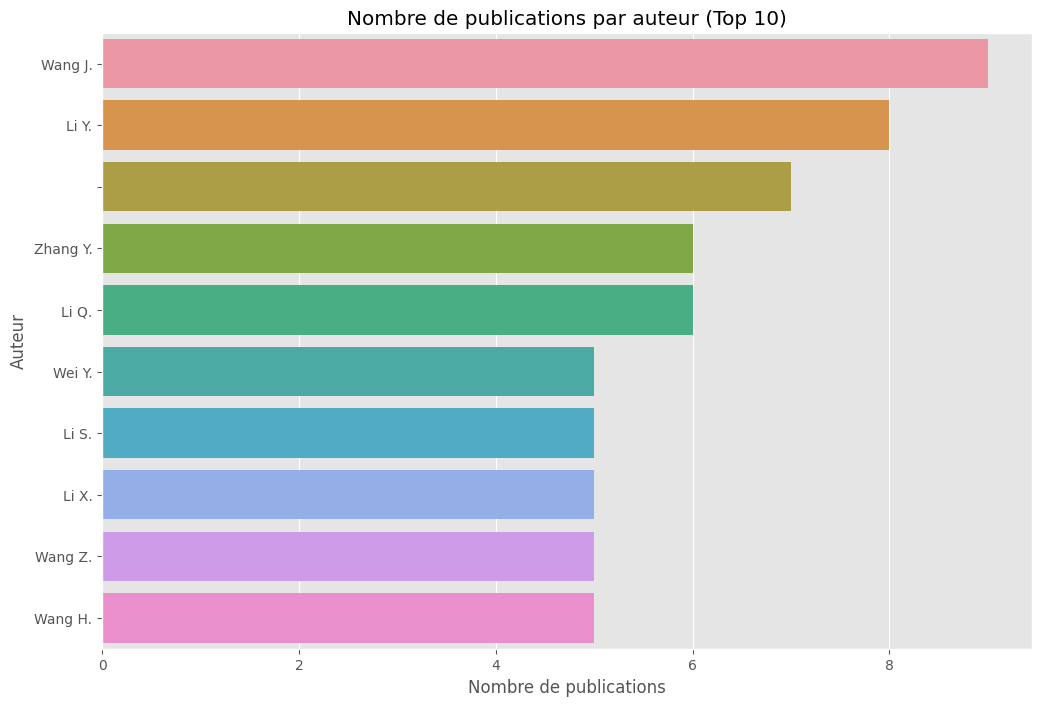

In [10]:
plt.figure(figsize=(12, 8))
top_authors_publications = df['authors'].value_counts().head(10)
sns.barplot(x=top_authors_publications.values, y=top_authors_publications.index, orient='h')
plt.title('Nombre de publications par auteur (Top 10)')
plt.xlabel('Nombre de publications')
plt.ylabel('Auteur')
plt.show()


##### Nombre de publications par année
Visualisation des tendances de publication au fil du temps.

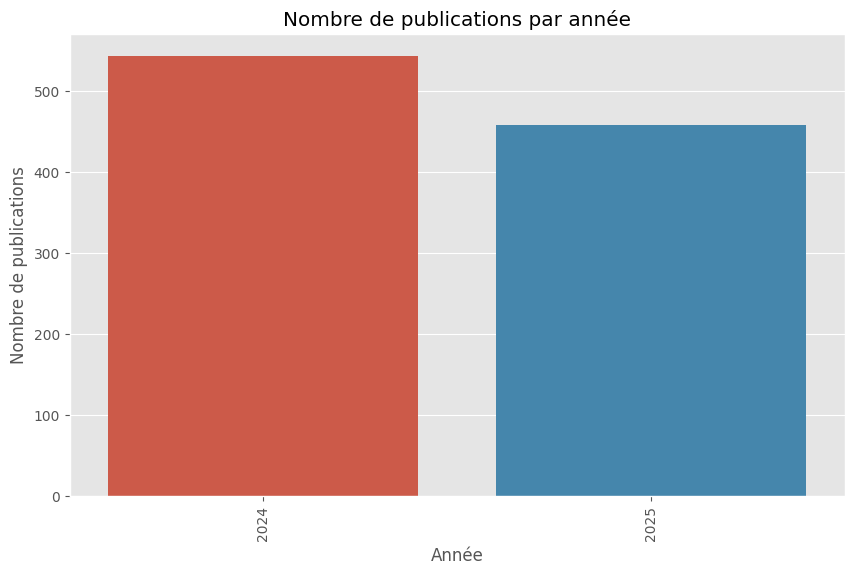

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='year')
plt.title('Nombre de publications par année')
plt.xlabel('Année')
plt.ylabel('Nombre de publications')
plt.xticks(rotation=90)
plt.show()


##### Répartition des publications par journal
Identification des journaux les plus populaires.

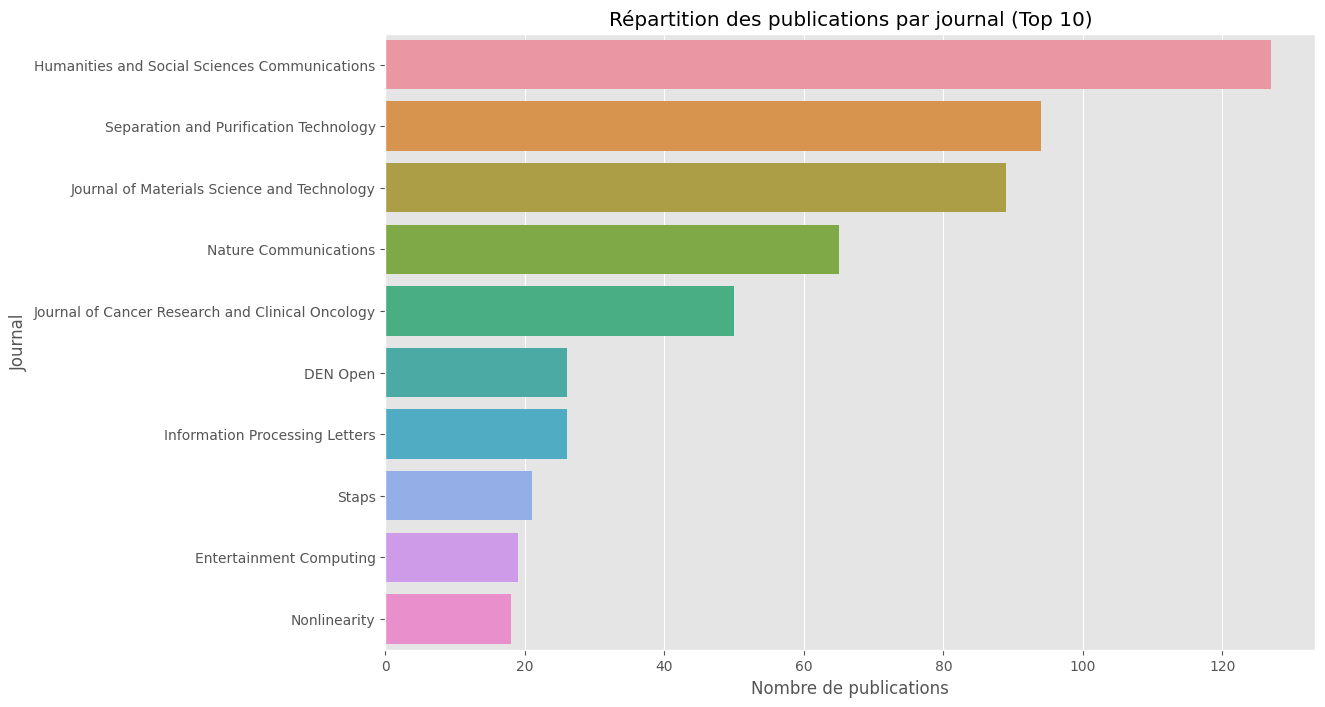

In [12]:
plt.figure(figsize=(12, 8))
top_journals = df['publicationName'].value_counts().head(10)
sns.barplot(x=top_journals.values, y=top_journals.index, orient='h')
plt.title('Répartition des publications par journal (Top 10)')
plt.xlabel('Nombre de publications')
plt.ylabel('Journal')
plt.show()


##### Répartition des publications par sujet (topic)
Visualisation des sujets les plus étudiés.

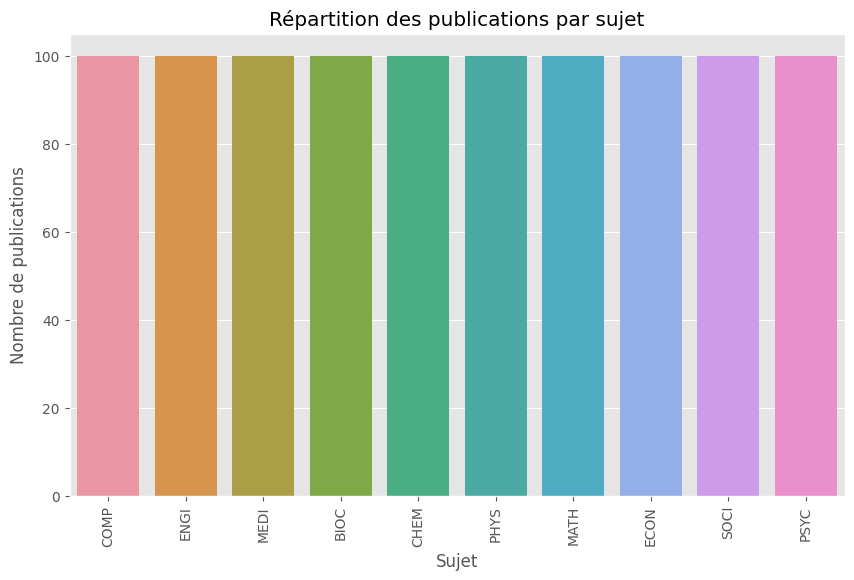

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='topic')
plt.title('Répartition des publications par sujet')
plt.xlabel('Sujet')
plt.ylabel('Nombre de publications')
plt.xticks(rotation=90)
plt.show()



#### 3. Analyse des affiliations
##### Répartition des publications par affiliation
Identification des institutions les plus actives.



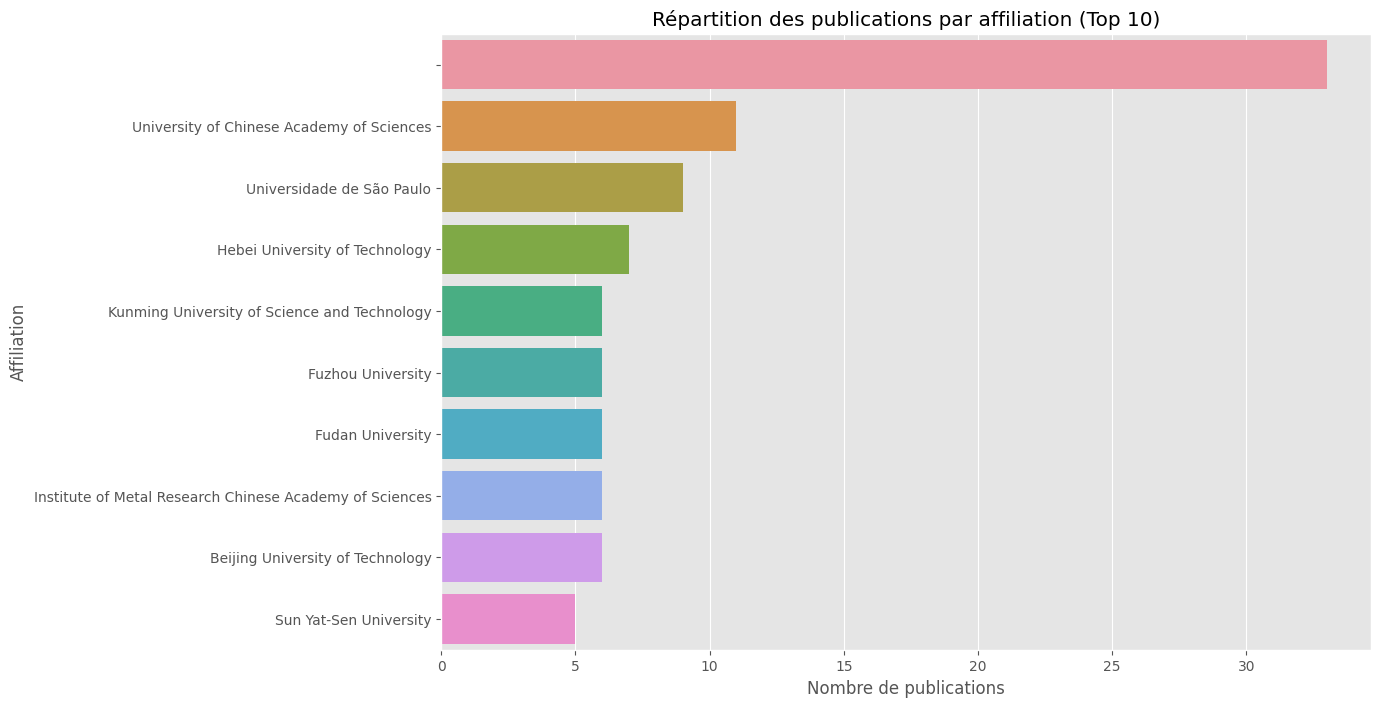

In [14]:
plt.figure(figsize=(12, 8))
top_affiliations = df['affilname'].value_counts().head(10)
sns.barplot(x=top_affiliations.values, y=top_affiliations.index, orient='h')
plt.title('Répartition des publications par affiliation (Top 10)')
plt.xlabel('Nombre de publications')
plt.ylabel('Affiliation')
plt.show()


##### Répartition géographique des affiliations par pays
Visualisation de la distribution des publications par pays.

In [31]:
import plotly.express as px

country_counts = df['affiliation-country'].value_counts()

fig = px.choropleth(locations=country_counts.index,
                    locationmode='country names',
                    color=country_counts.values,
                    hover_name=country_counts.index,
                    title='Répartition géographique des affiliations par pays')
fig.show()


##### Répartition géographique des Top 10  des affiliations


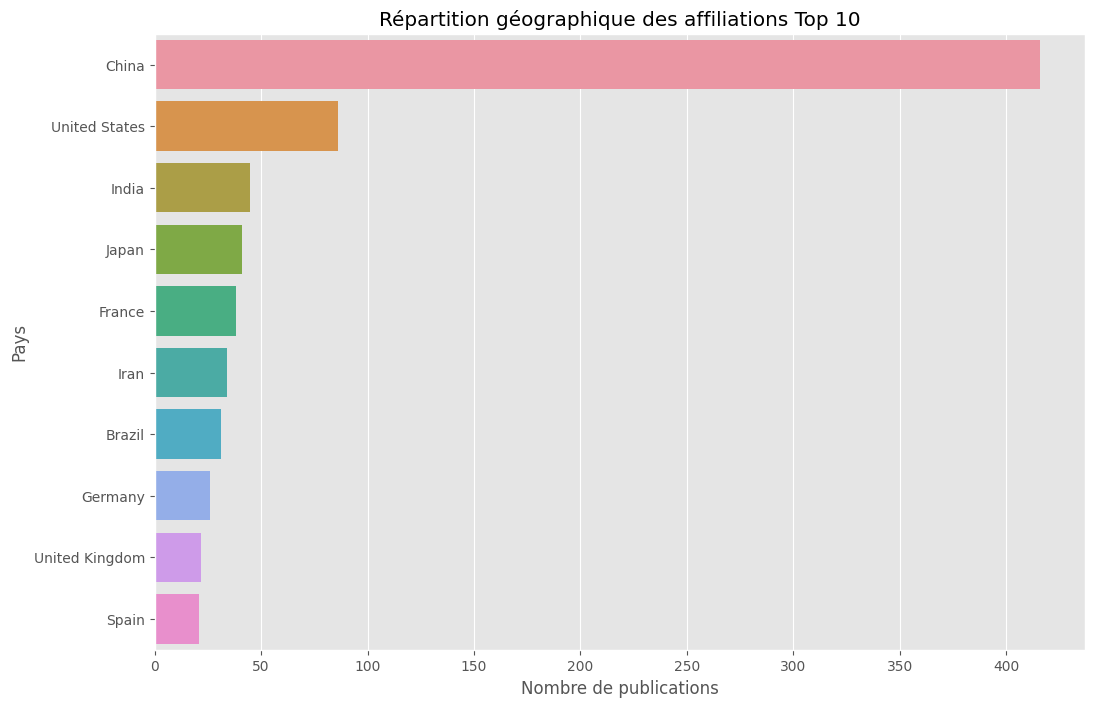

In [15]:
plt.figure(figsize=(12, 8))
top_countries = df['affiliation-country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, orient='h')
plt.title('Répartition géographique des affiliations Top 10')
plt.xlabel('Nombre de publications')
plt.ylabel('Pays')
plt.show()



##### Top 10 des affiliations les plus actives en termes de publications

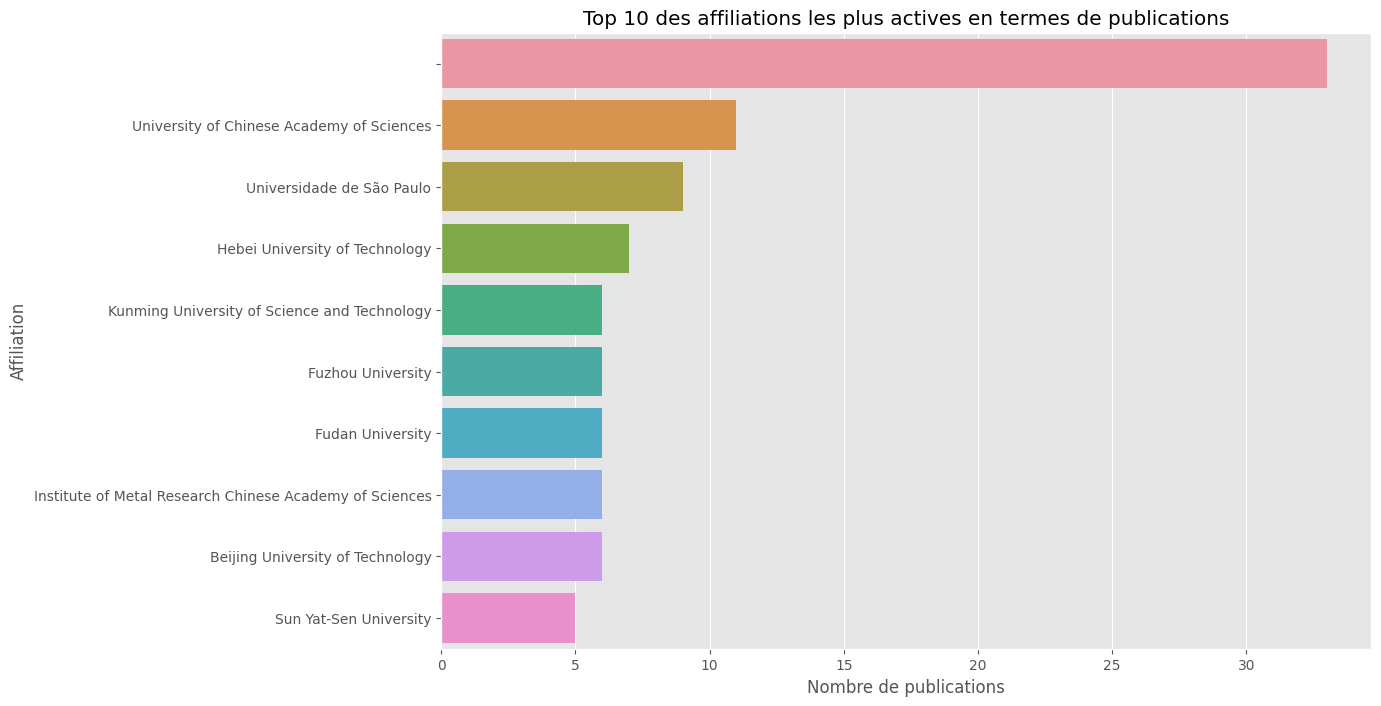

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(12, 8))
top_affiliations = df['affilname'].value_counts().head(10)
sns.barplot(x=top_affiliations.values, y=top_affiliations.index, orient='h')
plt.title('Top 10 des affiliations les plus actives en termes de publications')
plt.xlabel('Nombre de publications')
plt.ylabel('Affiliation')
plt.show()



##### Influence des affiliations sur le nombre de citations
L'analyse de l'influence des affiliations sur le nombre de citations vise à déterminer si certaines institutions ou affiliations académiques ont tendance à produire des travaux qui sont cités plus fréquemment que ceux d'autres institutions.

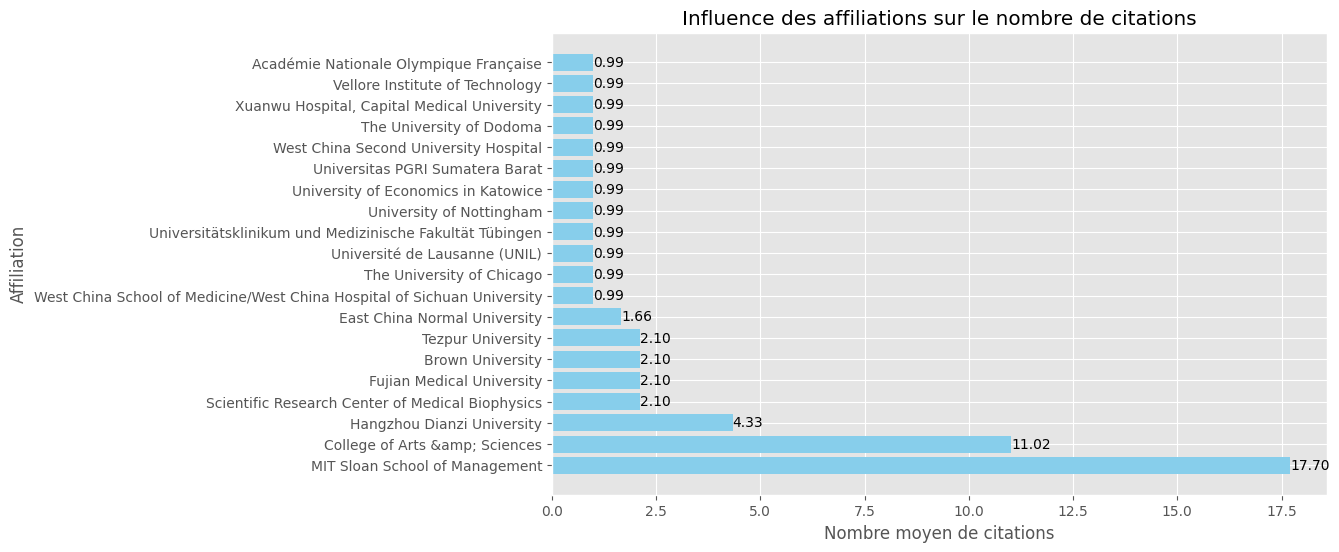

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

df['citedbyCount'] = df['citedbyCount'].astype(float)

affiliation_analysis = df.groupby('affilname')['citedbyCount'].mean().reset_index()

filtered_affiliation_analysis = affiliation_analysis[affiliation_analysis['citedbyCount'] > -0.1]

sorted_affiliation_analysis = filtered_affiliation_analysis.sort_values(by='citedbyCount', ascending=False)

top_affiliations = sorted_affiliation_analysis.head(20)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_affiliations['affilname'], top_affiliations['citedbyCount'], color='skyblue')
plt.xlabel('Nombre moyen de citations')
plt.ylabel('Affiliation')
plt.title('Influence des affiliations sur le nombre de citations')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}', va='center')

plt.show()


##### Sujets les plus fréquemment étudiés

  topic  count
0  COMP    100
1  ENGI    100
2  MEDI    100
3  BIOC    100
4  CHEM    100
5  PHYS    100
6  MATH    100
7  ECON    100
8  SOCI    100
9  PSYC    100


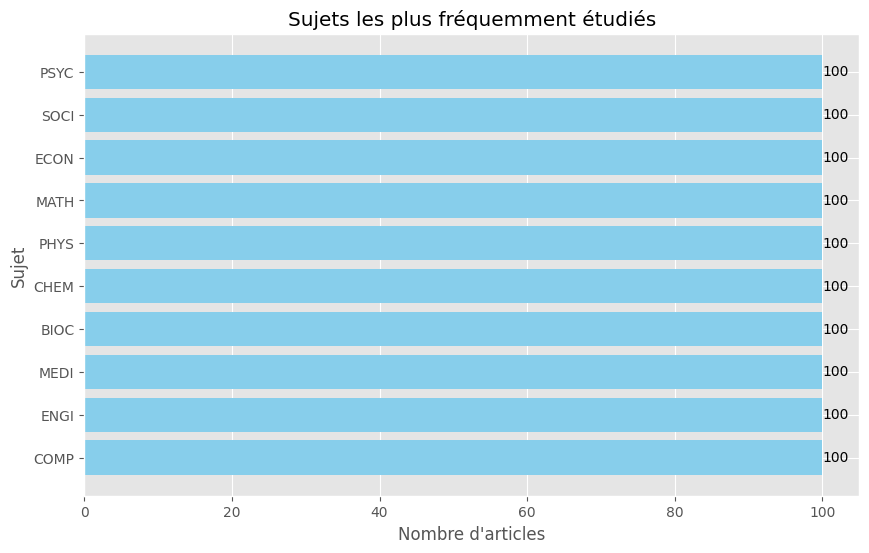

In [19]:
import pandas as pd
import matplotlib.pyplot as plt



topic_analysis = df['topic'].value_counts().reset_index()
topic_analysis.columns = ['topic', 'count']

print(topic_analysis)

top_topics = topic_analysis.head(20)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_topics['topic'], top_topics['count'], color='skyblue')
plt.xlabel('Nombre d\'articles')
plt.ylabel('Sujet')
plt.title('Sujets les plus fréquemment étudiés')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.0f}', va='center')

plt.show()


#### Analyse temporelle
##### Nombre de publications par mois/année
Identification des périodes les plus productives.

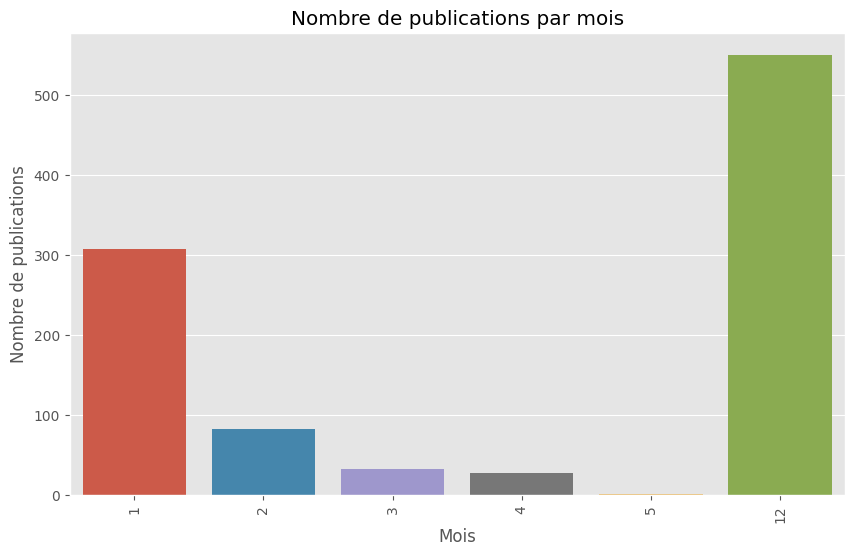

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='month')
plt.title('Nombre de publications par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de publications')
plt.xticks(rotation=90)
plt.show()


#### Analyse des journaux et des conférences
##### Répartition des publications par nom de publication (journal/conference)
Visualisation des journaux ou conférences les plus souvent choisis pour la publication.

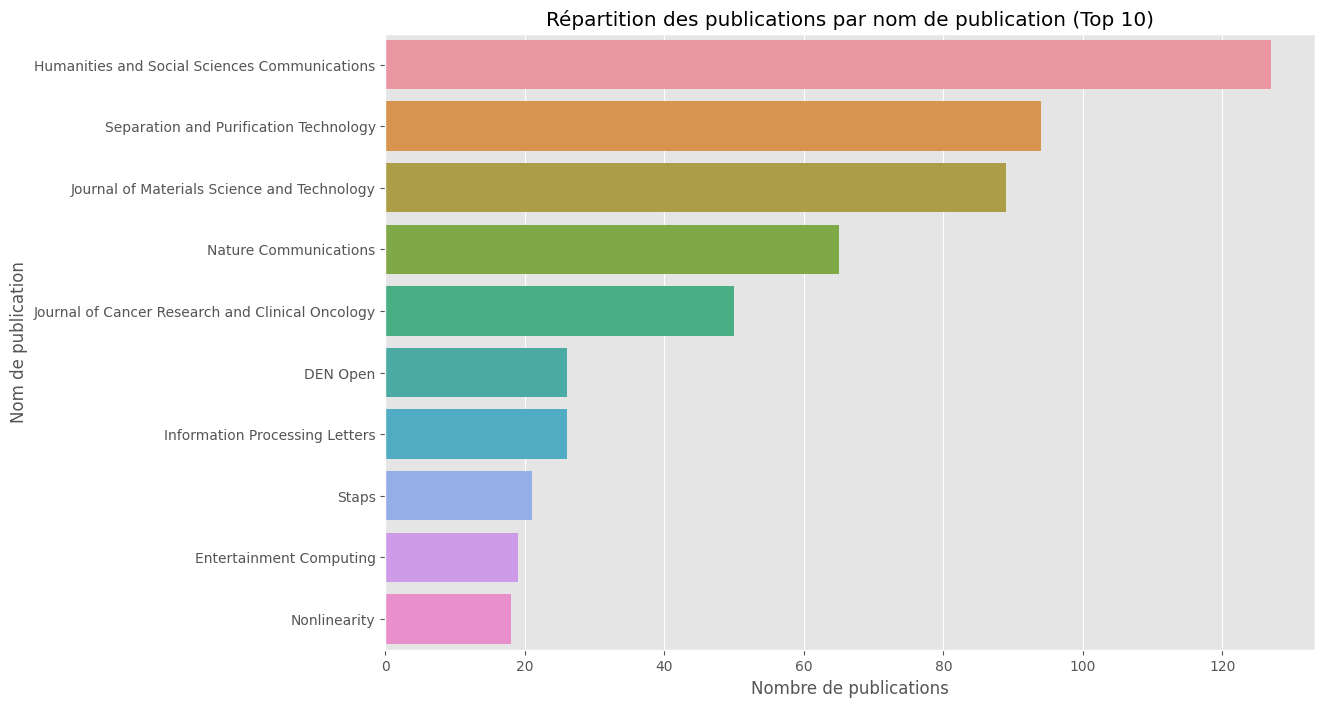

In [21]:
plt.figure(figsize=(12, 8))
top_publications = df['publicationName'].value_counts().head(10)
sns.barplot(x=top_publications.values, y=top_publications.index, orient='h')
plt.title('Répartition des publications par nom de publication (Top 10)')
plt.xlabel('Nombre de publications')
plt.ylabel('Nom de publication')
plt.show()


##### Sentiment Analysis (titre)

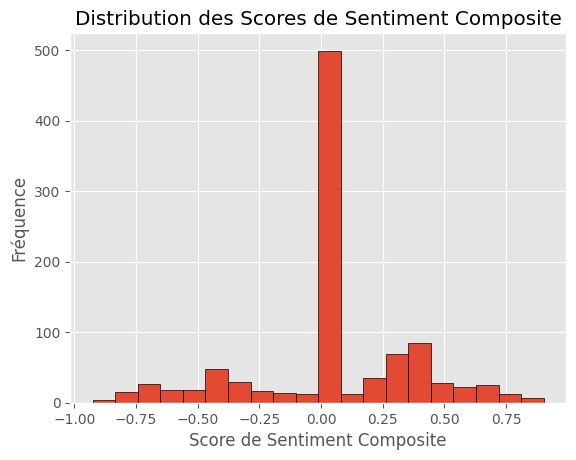

                                                 title  compound  positive  \
0    Survey of techniques to detect common weakness...   -0.3612     0.000   
1    An approach for assessing the functional vulne...   -0.1531     0.000   
2    Authentication, access control and scalability...    0.0000     0.000   
3    Securing IoT devices with fast and energy effi...    0.8531     0.508   
4    A Kriging Surrogate Model for Ball Grid Array ...    0.0000     0.000   
..                                                 ...       ...       ...   
995  Personal ideal, cultural ideal and optimal att...    0.9022     0.446   
996  Remote feedback in endovascular simulation tra...    0.0000     0.000   
997  CEO overseas experience, dynamic capabilities ...    0.3818     0.178   
998  Broad concepts of mental disorder predict self...   -0.4019     0.000   
999  Allport, Aristotle and Aquinas: An interdiscip...    0.0000     0.000   

     neutral  negative  
0      0.783     0.217  
1      0.862 

In [22]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt


def clean_title(title):
    title = re.sub(r'[^A-Za-z0-9 ]+', '', title)
    return title

df['cleaned_title'] = df['title'].apply(clean_title)

sia = SentimentIntensityAnalyzer()

def get_sentiment_score(title):
    sentiment = sia.polarity_scores(title)
    return sentiment

df['sentiment'] = df['cleaned_title'].apply(get_sentiment_score)

df['compound'] = df['sentiment'].apply(lambda x: x['compound'])
df['positive'] = df['sentment'].apply(lambda x: x['pos'])
df['neutral'] = df['sentiment'].apply(lambda x: x['neu'])
df['negative'] = df['sentiment'].apply(lambda x: x['neg'])

plt.hist(df['compound'], bins=20, edgecolor='black')
plt.title('Distribution des Scores de Sentiment Composite')
plt.xlabel('Score de Sentiment Composite')
plt.ylabel('Fréquence')
plt.show()

print(df[['title', 'compound', 'positive', 'neutral', 'negative']])



In [23]:
# Trier les publications par score de sentiment négatif (du plus élevé au plus bas)
df_sorted = df.sort_values(by='negative', ascending=False)

# Afficher les publications avec la négativité la plus élevée
print("Publications avec la négativité la plus élevée :")
print(df_sorted[['title', 'compound', 'positive', 'neutral', 'negative']].head(10))  # Affiche les 10 premières lignes pour exemple

Publications avec la négativité la plus élevée :
                                                 title  compound  positive  \
769  Media framing in Wirecard's fraud scandal: Fac...   -0.9217     0.000   
945  Repetition suppression between monetary loss a...   -0.6808     0.000   
288  Taste Disorder and Tongue Numbness After Lithi...   -0.5859     0.000   
906                             The world has gone mad   -0.4939     0.000   
863                             The world has gone mad   -0.4939     0.000   
919  Longitudinal associations of depression, anxie...   -0.9260     0.045   
339  Low-Dose Radiation Risks of Lymphohematopoieti...   -0.7579     0.000   
506  Low-Dose Radiation Risks of Lymphohematopoieti...   -0.7579     0.000   
316  An update of predictive biomarkers related to ...   -0.7845     0.000   
263  An update of predictive biomarkers related to ...   -0.7845     0.000   

     neutral  negative  
769    0.377     0.623  
945    0.517     0.483  
288    0.556     

In [24]:
# Trier les publications par score de sentiment positif (du plus élevé au plus bas)
df_sorted_positive = df.sort_values(by='positive', ascending=False)

# Afficher les publications avec la positivité la plus élevée
print("Publications avec la positivité la plus élevée :")
print(df_sorted_positive[['title', 'compound', 'positive', 'neutral', 'negative']].head(10))  # Affiche les 10 premières lignes pour exemple


Publications avec la positivité la plus élevée :
                                                 title  compound  positive  \
49   Safeguarding the Internet of Things: Elevating...    0.8979     0.569   
825  Safeguarding the Internet of Things: Elevating...    0.8979     0.569   
902                             The evolution of peace    0.5423     0.538   
338                             The evolution of peace    0.5423     0.538   
3    Securing IoT devices with fast and energy effi...    0.8531     0.508   
68   Discovering novel Cathepsin L inhibitors from ...    0.7096     0.497   
361  Discovering novel Cathepsin L inhibitors from ...    0.7096     0.497   
989  Praising pop emotions: media emotions serving ...    0.6705     0.478   
768  Praising pop emotions: media emotions serving ...    0.6705     0.478   
761  Assessing progress towards smart governance in...    0.6705     0.478   

     neutral  negative  
49     0.431     0.000  
825    0.431     0.000  
902    0.462     

##### Top 10 des Publications Positives VS Top 10 des Publications negatives

C:\Users\lenovo\AppData\Local\Temp\ipykernel_6560\2262633409.py:23: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



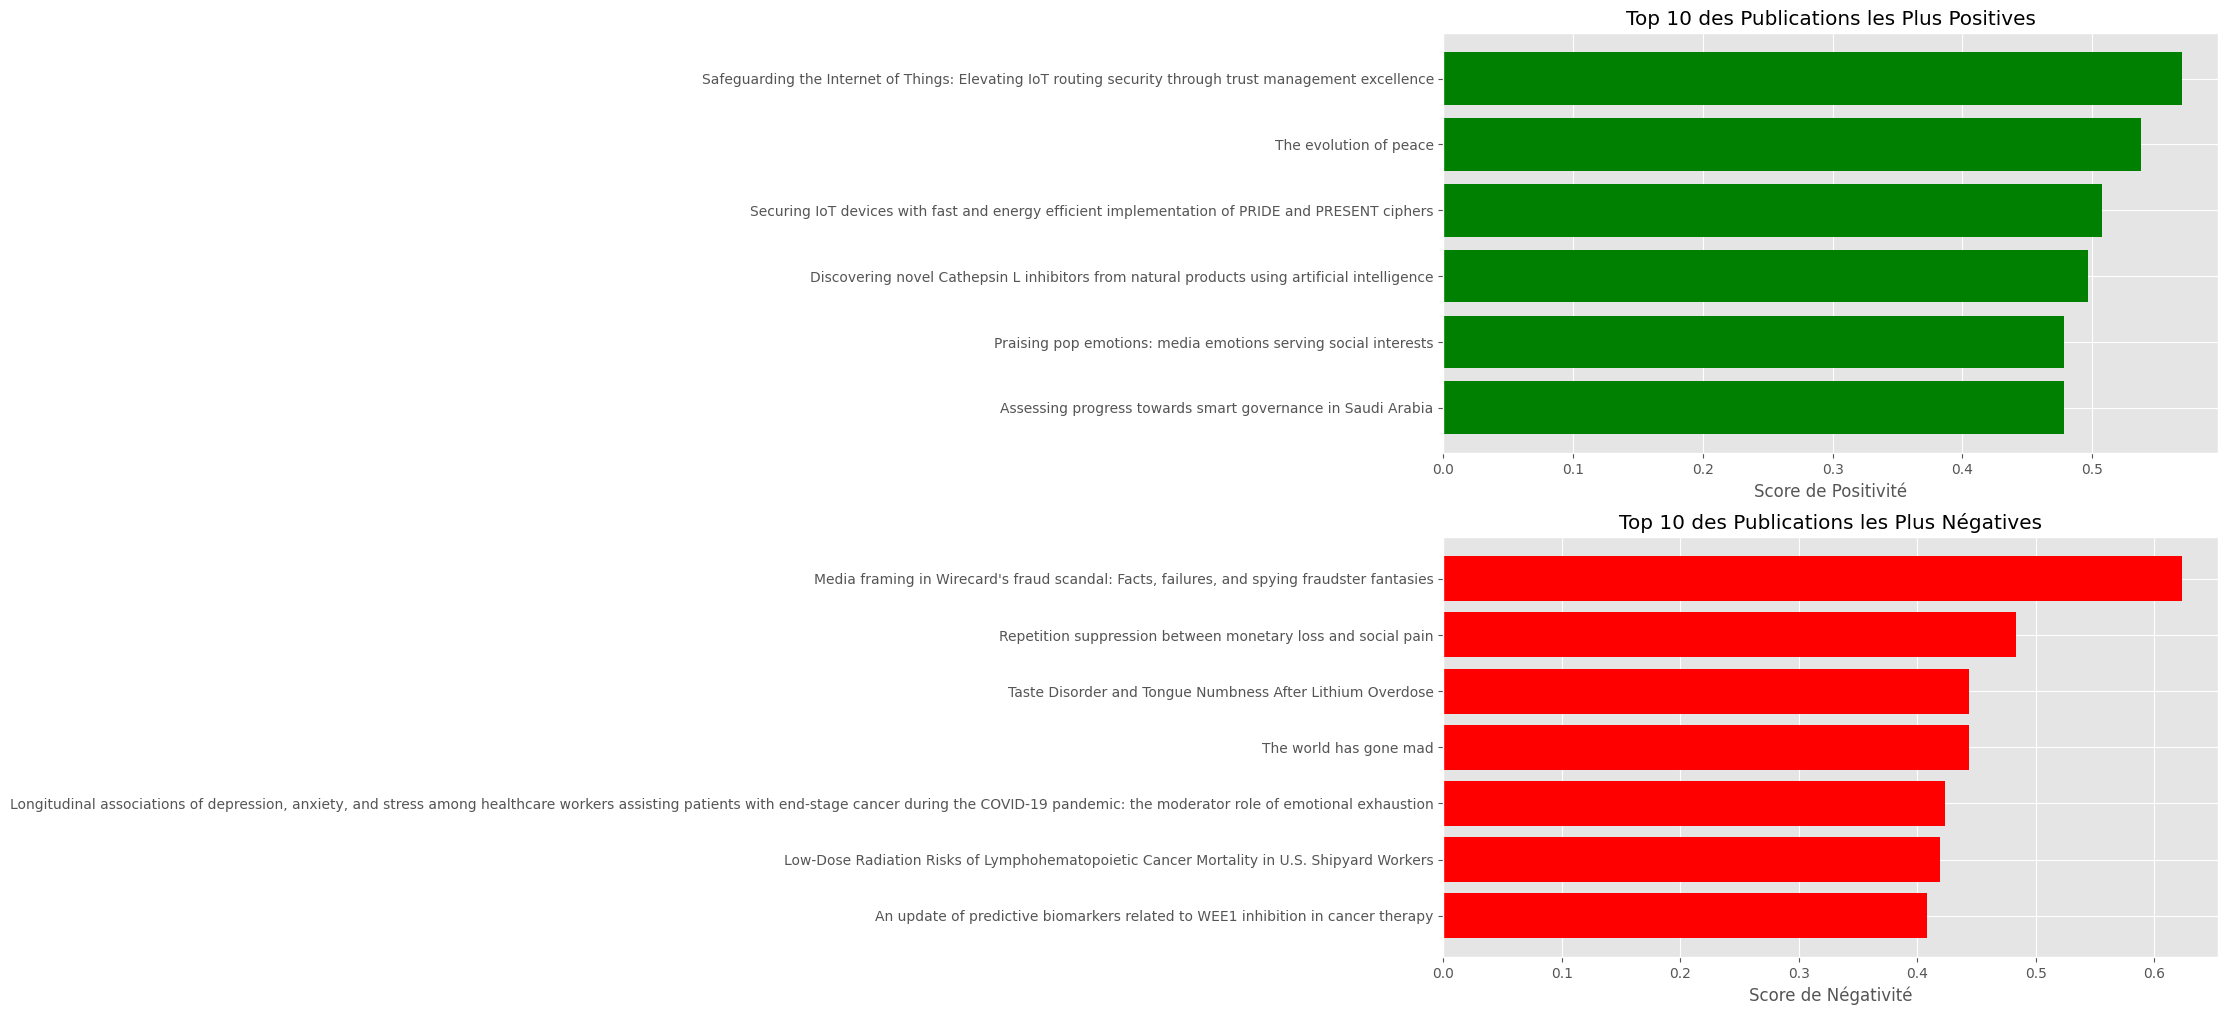

In [30]:
import matplotlib.pyplot as plt

df_sorted_positive = df.sort_values(by='positive', ascending=False).head(10)
df_sorted_negative = df.sort_values(by='negative', ascending=False).head(10)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Graphique pour les publications les plus positives
ax1.barh(df_sorted_positive['title'], df_sorted_positive['positive'], color='green')
ax1.set_xlabel('Score de Positivité')
ax1.set_title('Top 10 des Publications les Plus Positives')
ax1.invert_yaxis()  # Inverser l'axe y pour afficher les scores les plus élevés en haut

# Graphique pour les publications les plus négatives
ax2.barh(df_sorted_negative['title'], df_sorted_negative['negative'], color='red')
ax2.set_xlabel('Score de Négativité')
ax2.set_title('Top 10 des Publications les Plus Négatives')
ax2.invert_yaxis()  

fig.tight_layout(pad=3.0)

plt.show()


##### Répartition des publications par sujet et par sentiment

In [26]:
df['sentiment'] = pd.cut(df['compound'], bins=[-1, -0.1, 0.1, 1], labels=['negative', 'neutral', 'positive'])

# Calculer le nombre de publications par sujet et par sentiment
df_counts = df.groupby(['topic', 'sentiment']).size().unstack(fill_value=0)

# Calculer le pourcentage de publications par sentiment
df_percentage = df_counts.div(df_counts.sum(axis=1), axis=0) * 100

print("Répartition des publications par sujet et par sentiment :")
print(df_percentage)

Répartition des publications par sujet et par sentiment :
sentiment  negative  neutral  positive
topic                                 
BIOC           34.0     50.0      16.0
CHEM           16.0     42.0      42.0
COMP           17.0     45.0      38.0
ECON           17.0     45.0      38.0
ENGI           10.0     49.0      41.0
MATH           16.0     55.0      29.0
MEDI           30.0     54.0      16.0
PHYS           14.0     65.0      21.0
PSYC           28.0     42.0      30.0
SOCI           12.0     62.0      26.0


##### Répartition des Publications par Sentiment

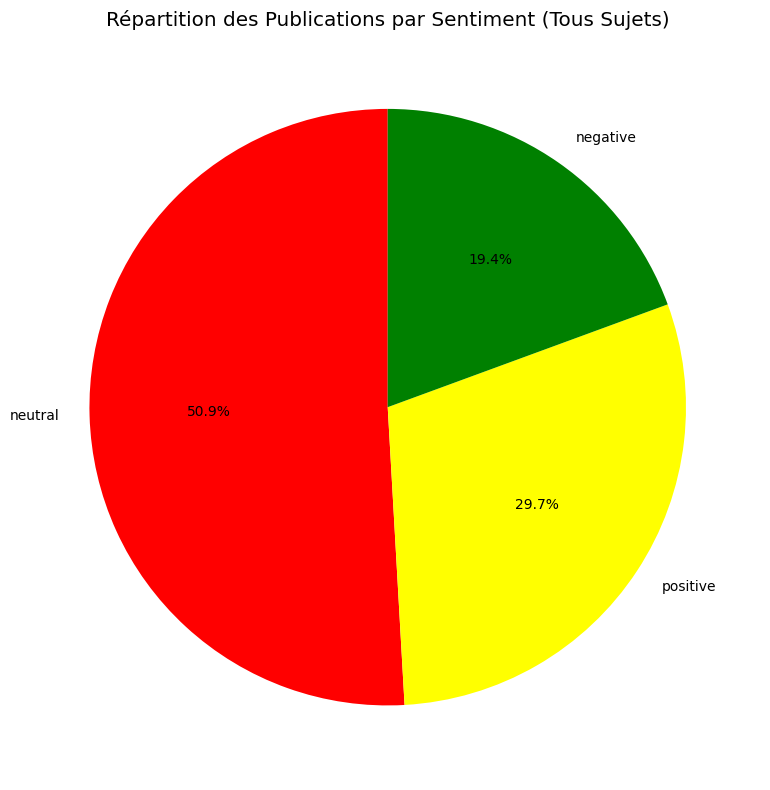

In [27]:
df['sentiment'] = pd.cut(df['compound'], bins=[-1, -0.1, 0.1, 1], labels=['negative', 'neutral', 'positive'])

df_counts = df['sentiment'].value_counts()

df_percentage = df_counts / df_counts.sum() * 100

plt.figure(figsize=(8, 8))
plt.pie(df_percentage, labels=df_percentage.index, autopct='%1.1f%%', startangle=90, colors=['red', 'yellow', 'green'])
plt.title('Répartition des Publications par Sentiment')

plt.tight_layout()
plt.show()

##### Répartition des Publications par Sujet et Sentiment

In [5]:
git init


SyntaxError: invalid syntax (3277417328.py, line 1)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df['sentiment'] = pd.cut(df['compound'], bins=[-1, -0.1, 0.1, 1], labels=['negative', 'neutral', 'positive'])
df = pd.read_csv('your_data_file.csv')

df_counts = df.groupby(['topic', 'sentiment']).size().unstack(fill_value=0)

df_percentage = df_counts.div(df_counts.sum(axis=1), axis=0) * 100

ax = df_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))

ax.set_xlabel('Sujet')
ax.set_ylabel('Pourcentage')
ax.set_title('Répartition des Publications par Sujet et Sentiment')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

ax.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()


NameError: name 'df' is not defined